In [1]:
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs

# Read data

In [2]:
filename = "FOR_GAP_DECON.txt"
dt = 0.004

with open(filename, "r") as f:
    data_str = f.read()
    

signal = np.array(data_str.split(), dtype=np.float)
tr = obs.Trace(signal, header={"delta":dt})

# Q1

## Plot

In [3]:
def plot_trace(tr):
    
    """
    """
    plt.figure(figsize=(9,3))
    
    plt.plot(tr.times(), tr)
    
    plt.xlabel("time [sec]")
    plt.ylabel("amplitude")
    plt.grid()
    

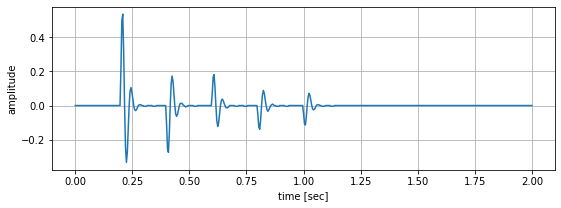

In [4]:
plot_trace(tr)

## Plot estimated source wavelet

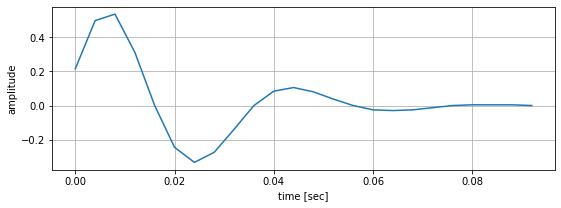

In [5]:
t = tr.stats.starttime
w = tr.slice(starttime=t+0.20, endtime=t+0.292)

plot_trace(w)

## Calculate auto correlation function of source wavelet

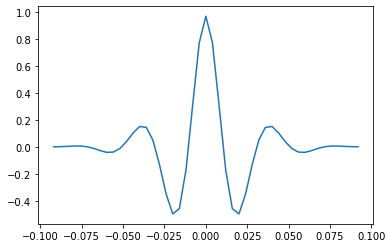

In [6]:
acf = np.correlate(w, w, mode="full")
mid_idx = len(acf)//2

%matplotlib inline
lag = np.arange(-mid_idx, mid_idx+1) * dt
plt.plot(lag, acf)
plt.show()

## Build shaping filter

In [7]:
# add prewhitening
acf[mid_idx] = acf[mid_idx] * 1.005

# construct toepliz matrix
A = np.squeeze([np.roll(acf, i)[mid_idx:] for i in range(mid_idx+1)])

# looking for an inverse filter f with the same length of w
# so the desired spike output of convolution of f with w should of length 2*len(w) -1 
spike = np.zeros( 2*len(w) - 1 )
spike[0] = 1

# cc
b = np.correlate(spike, w)

# solve linear system to get inverse filter
f = np.linalg.solve(A, b)

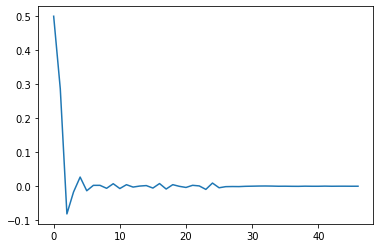

In [8]:
# check inverse filter by convoluting with source wavelet, should producesomething close to delta function
plt.plot(np.convolve(f, w))
plt.show()

## Filter original seismogram

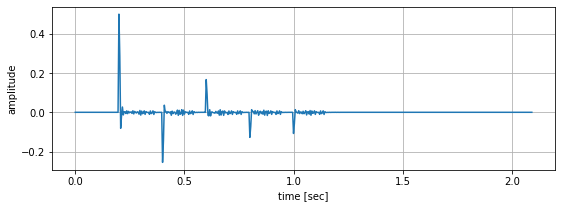

In [9]:
tr_filtered = obs.Trace(np.convolve(f, tr), header={"delta":dt})
plot_trace(tr_filtered)

# Q2

In [10]:
# calculate alpha - shift. Number of dt intervals until first wave in seismogram
alpha = int(0.2 / dt)

In [11]:
# autocorrelation to seismogram
acf = np.correlate(tr, tr, mode="full")
mid_idx = len(acf)//2

# add prewhitening
acf[mid_idx] = acf[mid_idx] * 1.005

# construct toepliz matrix
A = np.squeeze([np.roll(acf, i)[mid_idx:] for i in range(mid_idx+1)])

# construct appropriate solutions vector from acf
b = np.pad(acf[mid_idx+alpha:], pad_width=(0,alpha))

# solve linear system to get inverse filter
f = np.linalg.solve(A, b)

# final adjustments to filter before applying on seismogram
f = -f
f = np.insert(f, 0, np.zeros(alpha-1))    # prepend (alpha-1) zeros
f = np.insert(f, 0, 1)    # prepend 1

## Use filter on original seismogram

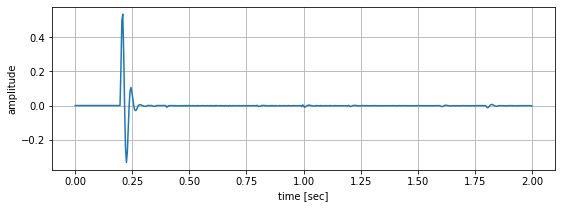

In [12]:
# apply filter and store
tr_filtered = np.convolve(f, tr)[:len(tr)]
tr_filtered = obs.Trace(tr_filtered, header={"delta":dt})

# plot
plot_trace(tr_filtered)